_This notebook contains code and comments from Section 6.1 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

## 6.1	Newton's Method for Minimization

When learning a machine learning model, we typically aim to find the model that fits the training data. The "goodness of this fit" is measured using the loss function. Model training is essentially finding the model parameters that minimize the loss function. Training of most machine learning algorithms can ultimately be cast into this framework, and attemtp to minimize the loss function in many different ways.

[Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is one such way. It is an iterative technique that can be used to find the (local) minimimum of an objective function. It is an example of a first-order optimization technique as it uses first-derivative information, that is, the gradient.


---
### 6.1.1 Newton's Method with an Illustrative Example
We will again use the [Branin function](https://uqworld.org/t/branin-function/53) as a test function to visualize how gradient descent works. Recall that the Branin function is a function of two variables $w_1$ and $w_2$:

\\[
f(w_1, w_2) = a (w_2 - b w_1^2 + c w_1 - r)^2 + s (1-t) \cos{w_1} + s
\\]

Since we will be performing Newton descent, we will need the gradient of $f(w_1, w_2)$ with respect to both $w_1$ and $w_2$:

\\[
g(w_1, w_2) = \left[ \begin{array}{c} 
    \frac{\partial f(w_1, w_2)}{\partial w_1} \\ 
    \frac{\partial f(w_1, w_2)}{\partial w_2} 
    \end{array} \right] 
    = \left[ \begin{array}{c} 
    2a(w_2 - b w_1^2 + c w_1 - r) \cdot (-2 b w_1 + c) - s (1 - t) \sin{w_1} \\ 
    2a(w_2 - b w_1^2 + c w_1 - r) \end{array} \right],
\\]

and the Hessian matrix of $f(w_1, w_2)$:

\\[
H(w_1, w_2) = \left[ \begin{array}{cc} 
    \frac{\partial}{\partial w_1} \frac{\partial f(w_1, w_2)}{\partial w_1}, & \frac{\partial}{\partial w_2} \frac{\partial f(w_1, w_2)}{\partial w_1} \\ 
    \frac{\partial}{\partial w_1} \frac{\partial f(w_1, w_2)}{\partial w_2}, & \frac{\partial}{\partial w_2} \frac{\partial f(w_1, w_2)}{\partial w_2} 
    \end{array} \right] 
    = \left[ \begin{array}{c} 
    2a(- 2 b w_1 + c)^2 - 4ab (w_2 - b w_1^2 + c w_1 - r) - s (1 - t) \cos{w_1}, & 2a(- 2 b w_1 + c) \\ 
    2a(- 2 b w_1 + c), 2a \end{array} \right],
\\]

In [1]:
import numpy as np

def branin(w, a, b, c, r, s, t):
    return a * (w[1] - b * w[0] ** 2 + c * w[0] - r) ** 2 + s * (1 - t) * np.cos(w[0]) + s


def branin_gradient(w, a, b, c, r, s, t):
    return np.array([2 * a * (w[1] - b * w[0] ** 2 + c * w[0] - r) * (-2 * b * w[0] + c) - s * (1 - t) * np.sin(w[0]),
                     2 * a * (w[1] - b * w[0] ** 2 + c * w[0] - r)])

def branin_hessian(w, a, b, c, r, s, t):
    return np.array([[2 * a * (- 2 * b * w[0] + c)** 2 -
                      4 * a * b * (w[1] - b * w[0] ** 2 + c * w[0] - r) - 
                      s * (1 - t) * np.cos(w[0]), 
                      2 * a * (- 2 * b * w[0] + c)],
                     [2 * a * (- 2 * b * w[0] + c), 
                     2 * a]])

In [2]:
# Check the Hessian matrix by comparing it with an approximation
from scipy.optimize import approx_fprime
a, b, c, r, s, t = 1, 5.1 / (4 * np.pi ** 2), 5 / np.pi, 6, 10, 1 / (8 * np.pi)

def g0(x, a, b, c, r, s, t):
    return branin_gradient(x, a, b, c, r, s, t)[0]
def g1(x, a, b, c, r, s, t):
    return branin_gradient(x, a, b, c, r, s, t)[1]
z = np.array([3, -4])

# Approximate the Hessian numerically
epsilon = 1e-6
Happrox = np.array([approx_fprime(z, g0, epsilon, a, b, c, r, s, t), 
                    approx_fprime(z, g1, epsilon, a, b, c, r, s, t)])
print(Happrox)

# Evaluate the Hessian using our implemented formula
Heval = branin_hessian(z, a, b, c, r, s, t)
print(Heval)

# Compute the error between the two; should be O(epsilon) ~ 10e-6 (ish)
print('Reconstruction error = {0}'.format(np.linalg.norm(Happrox - Heval)))

[[14.14010475  1.63288475]
 [ 1.63288449  2.        ]]
[[14.1401047   1.63288475]
 [ 1.63288475  2.        ]]
Reconstruction error = 2.6166166182922553e-07


In [3]:
# Set the constants of the Branin function
a, b, c, r, s, t = 1, 5.1 / (4 * np.pi ** 2), 5 / np.pi, 6, 10, 1 / (8 * np.pi)

# Set plotting boundaries and generate the mesh
w1Min, w1Max, w2Min, w2Max = -5, 18, -10, 18
w1, w2 = np.meshgrid(np.arange(w1Min, w1Max, 0.1),
                     np.arange(w2Min, w2Max, 0.1))

# Compute the Branin function over this mesh
z = np.apply_along_axis(branin, 1, np.c_[w1.ravel(), w2.ravel()], a, b, c, r, s, t)
z = z.reshape(w1.shape)

C:\Users\gauta\AppData\Local\Temp\ipykernel_53404\1741731818.py:21: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 9


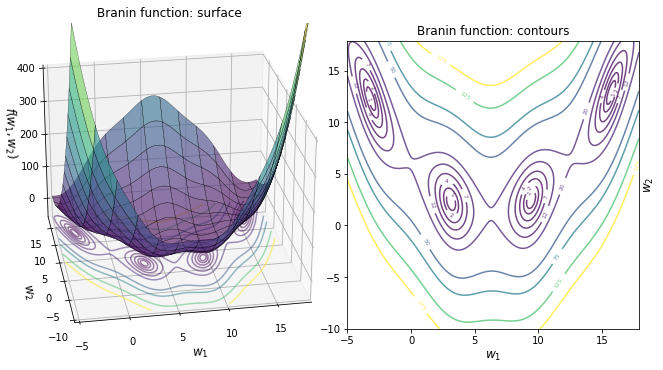

In [4]:
import matplotlib.pyplot as plt

# Visualize the Branin function in 3d
fig = plt.figure(figsize=(9, 5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_position([0.025, 0.15, 0.5, 0.9])

ax.plot_surface(w1, w2, z, rstride=20, cstride=20, alpha=0.6, linewidth=0.25, edgecolors='k', cmap='viridis')
ax.view_init(elev=25.0, azim=-100.0)
ax.contour(w1, w2, z, zdir='z', levels=np.array([1, 2, 4, 7, 12, 20, 50, 75, 125, 175]), 
           offset=-50, cmap='viridis', alpha=0.5)

ax.set_xlabel('$w_1$', fontsize=12)
ax.set_xlim(w1Min, w1Max)
ax.set_ylabel('$w_2$', fontsize=12)
ax.set_ylim(w2Min, w2Max)
ax.set_zlabel('$f(w_1, w_2)$', fontsize=12)
ax.set_zlim(-50, 400)
ax.set_zticks([0, 100, 200, 300, 400])
ax.dist = 9
ax.set_title('Branin function: surface', fontsize=12);

# Visualize the Branin function in 2d
ax = fig.add_subplot(1, 2, 2)
ax.set_position([0.55, 0.2, 0.45, 0.8])

ctr = ax.contour(w1, w2, z, levels=np.array([1, 2, 4, 7, 12, 20, 50, 75, 125, 175]), cmap='viridis', alpha=0.75)
ax.clabel(ctr, inline=1, fontsize=6)
ax.set_xlabel('$w_1$', fontsize=12)
ax.set_ylabel('$w_2$', fontsize=12)
ax.yaxis.set_label_position("right")
ax.set_title('Branin function: contours', fontsize=12);

# plt.savefig('./figures/CH06_F02_Kunapuli.png', format='png', dpi=300, bbox_inches='tight')
# plt.savefig('./figures/CH06_F02_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight')

This function has **four global minima**, which are the centers of the elliptical regions in contours. Newton's method descent will aim to find one of these four global minima. The pseudo-code for Newton's method follows these steps:

**Listing 6.1.** Newton's Descent
initialize: ``w_old`` = some initial guess
while not converged:
1. compute the gradient vector g and Hessian matrix H at the current estimate, w_old
2. compute the descent direction d = -inv(H) g 
3. set step length 0 <= α <= 1
4. update the solution: w_new  = w_old  + distance * direction= w_old  + α⋅ d
5. check for convergence: if amount of change between x_new and x_old is below our tolerance threshold

In [5]:
# Newton descent with function f, and gradient g
def newton_descent(f, g, h, x_init, max_iter=100, args=()):
    converged = False
    n_iter = 0

    x_old, x_new = np.array(x_init), None
    descent_path = np.full((max_iter + 1, 2), fill_value=np.nan)   # Save the descent path
    descent_path[n_iter] = x_old

    while not converged:
        n_iter += 1
        gradient, hessian = g(x_old, *args), h(x_old, *args)       # Compute the gradient and the Hessian       
        direction = -np.dot(np.linalg.inv(hessian), gradient)      # Compute the Newton direction
        distance = 1
        x_new = x_old + distance * direction                       # Compute the update
        descent_path[n_iter] = x_new

        # Update status
        # print('Iter {0:02d}: obj value = {1} (step={2}, dir={3}'.format(n_iter, step[3], step[0], direction))

        err = np.linalg.norm(x_new - x_old)                        # Compute amount of change between x_new and x_old
        if err <= 1e-3 or n_iter >= max_iter:                      # Check for convergence
            converged = True

        x_old = x_new                                              # Get ready for the next iteration

    return x_new, descent_path

We'd like to compare the descent paths of Newton descent with gradient descent. Let's also grab our gradient descent implementation from Section 5.1.

In [6]:
from scipy.optimize import line_search

# Gradient descent with function f, and gradient g
def gradient_descent(f, g, x_init, max_iter=100, args=()):
    converged = False
    n_iter = 0

    x_old, x_new = np.array(x_init), None
    descent_path = np.full((max_iter + 1, 2), fill_value=np.nan)   # Save the descent path
    descent_path[n_iter] = x_old

    while not converged:
        n_iter += 1
        gradient = -g(x_old, *args)                                # Compute the negative gradient
        direction = gradient / np.linalg.norm(gradient)            # Normalize the gradient 
        step = line_search(f, g, x_old, direction, args=args)      # Compute the step length using line search

        if step[0] is None:                     # If step length doesn't return a useful value, make it 1.0
            distance = 1.0
        else:
            distance = step[0]

        x_new = x_old + distance * direction                    # Compute the update
        descent_path[n_iter] = x_new

        # Update status
        # print('Iter {0:02d}: obj value = {1} (step={2}, dir={3}'.format(n_iter, step[3], step[0], direction))

        err = np.linalg.norm(x_new - x_old)                        # Compute amount of change between x_new and x_old
        if err <= 1e-3 or n_iter >= max_iter:                      # Check for convergence
            converged = True

        x_old = x_new                                              # Get ready for the next iteration

    return x_new, descent_path

We perform gradient descent on the Branin function, intializing our solution at $w = [2, -5]$, and visualize the solution paths of both Newton descent and gradient descent.

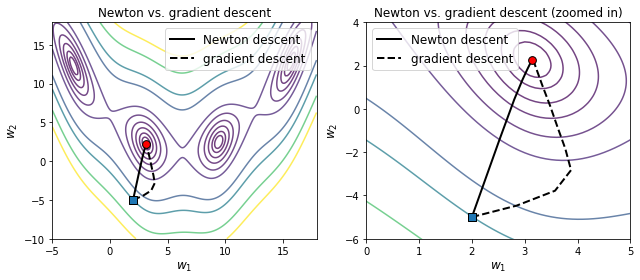

In [7]:
# Set the constants of the Branin function
a, b, c, r, s, t = 1, 5.1 / (4 * np.pi ** 2), 5 / np.pi, 6, 10, 1 / (8 * np.pi)

# Initialize and perform gradient descent
w_init = np.array([2, -5])
w_optimal, w_newton_path = newton_descent(branin, branin_gradient, branin_hessian, w_init, args=(a, b, c, r, s, t))
w_optimal, w_gradient_path = gradient_descent(branin, branin_gradient, w_init, args=(a, b, c, r, s, t))

# Plot optimization path over all iterations
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax[0].contour(w1, w2, z, levels=np.array([1, 2, 4, 7, 12, 20, 50, 75, 125, 175]), cmap='viridis', alpha=0.75)
ax[0].plot(w_newton_path[:, 0], w_newton_path[:, 1], 'k', linewidth=2)
ax[0].plot(w_gradient_path[:, 0], w_gradient_path[:, 1], 'k', linewidth=2, linestyle='--')
ax[0].scatter(w_init[0], w_init[1], s=60, marker='s', edgecolor='k', zorder=2)
ax[0].scatter(w_optimal[0], w_optimal[1], s=60, c='r', edgecolor='k', zorder=2)
ax[0].set_xlabel('$w_1$', fontsize=12)
ax[0].set_ylabel('$w_2$', fontsize=12)
ax[0].set_title('Newton vs. gradient descent', fontsize=12)
ax[0].legend(['Newton descent', 'gradient descent'], fontsize=12)

# # Plot optimization path zoomed in
ax[1].contour(w1, w2, z, levels=np.array([1, 2, 4, 7, 12, 20, 50, 75, 125, 175]), cmap='viridis', alpha=0.75)
ax[1].plot(w_newton_path[:, 0], w_newton_path[:, 1], 'k', linewidth=2)
ax[1].plot(w_gradient_path[:, 0], w_gradient_path[:, 1], 'k', linewidth=2, linestyle='--')
ax[1].scatter(w_init[0], w_init[1], s=60, marker='s', edgecolor='k', zorder=2)
ax[1].scatter(w_optimal[0], w_optimal[1], s=60, c='r', edgecolor='k', zorder=2)
ax[1].set_xlim(0, 5)
ax[1].set_ylim(-6, 4)
ax[1].set_xlabel('$w_1$', fontsize=12)
ax[1].set_ylabel('$w_2$', fontsize=12)
ax[1].set_title('Newton vs. gradient descent (zoomed in)', fontsize=12)
ax[1].legend(['Newton descent', 'gradient descent'], fontsize=12)

fig.tight_layout()
# plt.savefig('./figures/CH06_F03_Kunapuli.png', format='png', dpi=300, bbox_inches='tight')
# plt.savefig('./figures/CH06_F03_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [8]:
# Initialize at [5, 7] to show convergence to a saddle point
w_init = np.array([5, 7])
w_optimal, w_newton_path = newton_descent(branin, branin_gradient, branin_hessian, w_init, args=(a, b, c, r, s, t))


# Set plotting boundaries and generate the mesh
w1Min, w1Max, w2Min, w2Max = 1.5, 10, -5, 7.5
w1, w2 = np.meshgrid(np.arange(w1Min, w1Max, 0.1),
                     np.arange(w2Min, w2Max, 0.1))

# Compute the Branin function over this mesh
z = np.apply_along_axis(branin, 1, np.c_[w1.ravel(), w2.ravel()], a, b, c, r, s, t)
z = z.reshape(w1.shape)

C:\Users\gauta\AppData\Local\Temp\ipykernel_53404\3468660018.py:18: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 8


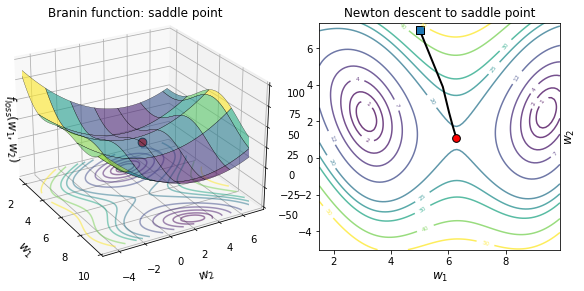

In [9]:
# Visualize the Branin function in 3d
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_position([0.025, 0.15, 0.5, 0.9])
ax.plot_surface(w1, w2, z, rstride=20, cstride=20, alpha=0.6, linewidth=0.25, edgecolors='k', cmap='viridis')
ax.view_init(elev=25.0, azim=-30.0)
ax.contour(w1, w2, z, zdir='z', levels=np.array([1, 2, 4, 7, 12, 20, 25, 30, 40, 50]), 
           offset=-50, cmap='viridis', alpha=0.5)

ax.scatter(w_optimal[0], w_optimal[1], branin(w_optimal, a, b, c, r, s, t), s=75, c='r', edgecolors='k', zorder=5, alpha=1) 
ax.set_xlabel('$w_1$', fontsize=12)
ax.set_xlim(w1Min, w1Max)
ax.set_ylabel('$w_2$', fontsize=12)
ax.set_ylim(w2Min, w2Max)
# ax.set_zlabel('$f(w_1, w_2)$')
ax.text(-3, -4, -75, '$f_{loss}(w_1, w_2)$', (0, 0, 1), fontsize=12)
ax.set_zlim(-50, 100)
ax.dist = 8
ax.set_title('Branin function: saddle point', fontsize=12)

# Visualize the Branin function in 2d
ax = fig.add_subplot(1, 2, 2)
# ax.set_position([0.55, 0.11, 0.425, 0.85])
ctr = ax.contour(w1, w2, z, levels=np.array([1, 2, 4, 7, 12, 20, 25, 30, 40, 50]), cmap='viridis', alpha=0.75)
ax.clabel(ctr, inline=1, fontsize=6)
ax.set_xlabel('$w_1$', fontsize=12)
ax.set_ylabel('$w_2$', fontsize=12)
ax.yaxis.set_label_position('right')
ax.set_title('Newton descent to saddle point', fontsize=12)

ax.plot(w_newton_path[:, 0], w_newton_path[:, 1], 'k', linewidth=2)
ax.scatter(w_init[0], w_init[1], s=60, marker='s', edgecolor='k', zorder=2)
ax.scatter(w_optimal[0], w_optimal[1], s=60, c='r', edgecolor='k', zorder=2)

fig.tight_layout()
# plt.savefig('./figures/CH06_F04_Kunapuli.png', format='png', dpi=300, bbox_inches='tight')
# plt.savefig('./figures/CH06_F04_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight')

---
### 6.1.2	Newton Descent over Loss Functions for Training

Let's consider a simple classification problem in a two-dimensional feature space

In [10]:
import matplotlib.cm as cm
import matplotlib.colors as col
import numpy as np

# Plot a 2D classification data set onto the specified axes
def plot_2d_data(ax, X, y, s=20, alpha=0.95, xlabel=None, ylabel=None, title=None, legend=None, colormap='viridis'):
    # Get data set size
    n_examples, n_features = X.shape

    # Check that the data set is 2D
    if n_features != 2:
        raise ValueError('Data set is not 2D!')

    # Check that the lengths of X and y match
    if n_examples != len(y):
        raise ValueError('Length of X is not equal to the length of y!')

    # Get the unique labels and set up marker styles and colors
    unique_labels = np.sort(np.unique(y))
    n_classes = len(unique_labels)

    markers = ['o', 's', '^', 'v', '<', '>', 'p']

    cmap = cm.get_cmap(colormap)
    colors = cmap(np.linspace(0, 0.5, num=n_classes))

    # Set marker sizes
    if isinstance(s, np.ndarray):
        # If its an ndarray, make sure it has the same size as the number of examples
        if len(s) != n_examples:
            raise ValueError('Length of s is not equal to the length of y!')
    else:
        # Otherwise, make it an nd_array
        s = np.full_like(y, fill_value=s)

    # Plot the data
    for i, label in enumerate(unique_labels):
        marker_color = col.rgb2hex(colors[i])
        marker_shape = markers[i % len(markers)]
        ax.scatter(X[y == label, 0], X[y == label, 1], s=s[y == label],
                   marker=marker_shape, 
                   c=marker_color, 
                   edgecolors='k', alpha=0.5)

    # Add labels, title and bounds
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=12)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=12)
    if title is not None:
        ax.set_title(title)

    # Set the legend
    if legend is not None:
        ax.legend(legend, fontsize=12);


# Plot a 2D classification function and/or corresponding data set onto the specified axes
def plot_2d_classifier(ax, X, y, predict_function, predict_args=None, predict_proba=False, boundary_level=0.5,
                       s=20, plot_data=True, alpha=0.75,
                       xlabel=None, ylabel=None, title=None, legend=None, colormap='viridis'):

    # Get the bounds of the plot and generate a mesh
    xMin, xMax = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
    yMin, yMax = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
    xMesh, yMesh = np.meshgrid(np.arange(xMin, xMax, 0.05),
                               np.arange(yMin, yMax, 0.05))

    # Compute predictions over the mesh
    if predict_proba:
        zMesh = predict_function(np.c_[xMesh.ravel(), yMesh.ravel()])[:, 1]
    elif predict_args is None:
        zMesh = predict_function(np.c_[xMesh.ravel(), yMesh.ravel()])
    else:
        zMesh = predict_function(np.c_[xMesh.ravel(), yMesh.ravel()], predict_args)
    zMesh = zMesh.reshape(xMesh.shape)

    # Plot the classifier
    ax.contourf(xMesh, yMesh, zMesh, cmap=colormap, alpha=alpha, antialiased=True)
    if boundary_level is not None:
        ax.contour(xMesh, yMesh, zMesh, [boundary_level], linewidths=3, colors='k')

    # Plot the data
    if plot_data:
        plot_2d_data(ax, X, y, s=s, xlabel=xlabel, ylabel=ylabel, title=title, legend=legend, colormap=colormap)

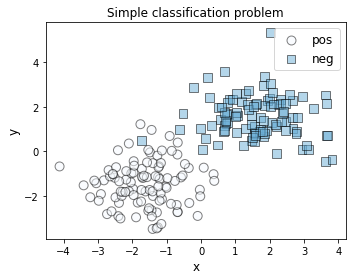

In [11]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=200, n_features=2, 
                  centers=[[-1.5, -1.5], [1.5, 1.5]], random_state=42)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
plot_2d_data(ax, X, y, xlabel='x', ylabel='y', alpha=0.3, s=80, 
             title='Simple classification problem', 
             legend=['pos', 'neg'], colormap='Blues')

fig.tight_layout()
# plt.savefig('./figures/CH06_F05_Kunapuli.png', format='png', dpi=300, bbox_inches='tight')
# plt.savefig('./figures/CH06_F05_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight')

We want to learn a linear classifier $h(\mathbf{x})$ of the form shown below:

\\[
h_\mathbf{w}(\mathbf{x}) = w_1 x_1 + w_2 x_2,
\\]

which takes a training example $\mathbf{x} = [x_1, x_2]^T$. The classifier is parameterized by $\mathbf{w} = [w_1, w_2]^T$, which we have to learn using the training examples. In order to train a classifier, we'll need a loss function. 

For this problem, we will chose the **squared loss** of the classifier $h_\mathbf{w}(\mathbf{x})$ over the training set of $n$ training examples $\mathbf{x}_i = [x_1^i, x_2^i]^T$, $i=1, ..., n$, with corresponding labels $y_i$.

\\[
f_{loss}(w_1, w_2) = \frac{1}{2} \sum_{i=1}^n \left( y_i - h_\mathbf{w}(\mathbf{x}_i) \right)^2 = \frac{1}{2} \sum_{i=1}^n \left( y_i - w_1 x_1^i - w_2 x_2^i \right)^2 = \frac{1}{2} (\mathbf{y} - X\mathbf{w})^T (\mathbf{y} - X\mathbf{w}).
\\]

Similar to the Branin function in Section 5.2.1, we can compute the gradient of this loss function with respect to $w_1$ and $w_2$.

\\[
g(w_1, w_2) = \left[ \begin{array}{c} 
    \frac{\partial f_{loss}(w_1, w_2)}{\partial w_1} \\ 
    \frac{\partial f_{loss}(w_1, w_2)}{\partial w_2} 
    \end{array} \right] 
    = \left[ \begin{array}{c} 
    - \sum_{i=1}^n \left( y_i - w_1 x_i - w_2 x_i \right) x_i\\ 
    - \sum_{i=1}^n \left( y_i - w_1 x_i - w_2 x_i \right) x_i \end{array} \right]
    = -X^T (\mathbf{y} - X\mathbf{w})
\\]

In addition, for Newton descent, we will also have to compute the Hessian matrix of the squared loss function
\\[
H(w_1, w_2) = \left[ \begin{array}{cc} 
    \frac{\partial f_{loss}(w_1, w_2)}{\partial w_1 w_1} & \frac{\partial f_{loss}(w_1, w_2)}{\partial w_1 w_2} \\ 
    \frac{\partial f_{loss}(w_1, w_2)}{\partial w_2 w_1} & \frac{\partial f_{loss}(w_1, w_2)}{\partial w_2 w_2}
    \end{array} \right] 
    = X^T X
\\]

In both the equations above, the expressions on the far right are the vectorized versions of the loss function, where $X$ is the data matrix and $\mathbf{y}$ is the label vector. The vectorized version is more compact and easier and more efficient to implement as it avoids explicit loops for summation. 

In [12]:
def squared_loss(w, X, y):
    return 0.5 * np.sum((y - np.dot(X, w))**2)

def squared_loss_gradient(w, X, y):
    return -np.dot(X.T, (y - np.dot(X, w)))

def squared_loss_hessian(w, X, y):
    return np.dot(X.T, X)

In [13]:
w_init = np.array([0.0, -0.99])
w_gradient, path_gradient = gradient_descent(squared_loss, squared_loss_gradient, w_init, args=(X, y))
w_newton, path_newton = newton_descent(squared_loss, squared_loss_gradient, squared_loss_hessian, w_init, args=(X, y))

# Compute the Loss function in this domain
w1Min, w1Max, w2Min, w2Max = -1, 1, -1, 1
w1, w2 = np.meshgrid(np.arange(w1Min, w1Max, 0.05),
                     np.arange(w2Min, w2Max, 0.05))
z = np.apply_along_axis(squared_loss, 1, np.c_[w1.ravel(), w2.ravel()], X, y)
z = z.reshape(w1.shape)

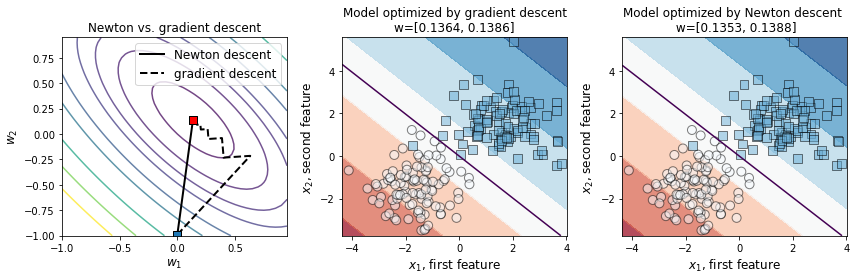

In [14]:
# Plot optimization path over all iterations
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax[0].contour(w1, w2, z, levels=np.array([25, 50, 100, 150, 200, 300, 400, 600, 800, 1000]),
              cmap='viridis', alpha=0.75)
ax[0].plot(path_newton[:, 0], path_newton[:, 1], 'k', linewidth=2)
ax[0].plot(path_gradient[:, 0], path_gradient[:, 1], 'k', linewidth=2, linestyle='--')
ax[0].set_xlabel('$w_1$', fontsize=12)
ax[0].set_ylabel('$w_2$', fontsize=12)
ax[0].set_title('Newton vs. gradient descent', fontsize=12)
ax[0].legend(['Newton descent', 'gradient descent'], fontsize=12)
ax[0].scatter(w_init[0], w_init[1], s=60, marker='s', edgecolor='k', zorder=2)
ax[0].scatter(w_gradient[0], w_gradient[1], c='r', s=60, marker='s', edgecolor='k', zorder=2)


# Plot the solution
xMin, xMax = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
yMin, yMax = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
xMesh, yMesh = np.meshgrid(np.arange(xMin, xMax, 0.05),
                           np.arange(yMin, yMax, 0.05))

# Plot the gradient descent trained classifier
zMesh = np.dot(np.c_[xMesh.ravel(), yMesh.ravel()], w_gradient)
zMesh = (zMesh.reshape(xMesh.shape) + 1) / 2
ax[1].contourf(xMesh, yMesh, zMesh, cmap='RdBu', alpha=0.75)
ax[1].contour(xMesh, yMesh, zMesh, levels=[0.5])
plot_2d_data(ax[1], X, y, colormap='Blues', alpha=0.4, s=80)
ax[1].set_xlabel('$x_1$, first feature', fontsize=12)
ax[1].set_ylabel('$x_2$, second feature', fontsize=12)
ax[1].set_title('Model optimized by gradient descent\nw=[{0:5.4f}, {1:5.4f}]'.format(w_gradient[0], w_gradient[1]), fontsize=12)

# Plot the Newton descent trained classifier
zMesh = np.dot(np.c_[xMesh.ravel(), yMesh.ravel()], w_newton)
zMesh = (zMesh.reshape(xMesh.shape) + 1) / 2
ax[2].contourf(xMesh, yMesh, zMesh, cmap='RdBu', alpha=0.75)
ax[2].contour(xMesh, yMesh, zMesh, levels=[0.5])
plot_2d_data(ax[2], X, y, colormap='Blues', alpha=0.4, s=80)
ax[2].set_xlabel('$x_1$, first feature', fontsize=12)
ax[2].set_ylabel('$x_2$, second feature', fontsize=12)
ax[2].set_title('Model optimized by Newton descent \n w=[{0:5.4f}, {1:5.4f}]'.format(w_newton[0], w_newton[1]), fontsize=12);

fig.tight_layout()
# plt.savefig('./figures/CH06_F06_Kunapuli.png', format='png', dpi=300, bbox_inches='tight')
# plt.savefig('./figures/CH06_F06_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight')

The performance of the final $\mathbf{w}$ is trained by performing Newton descent on the loss function can also be evaluated.

In [15]:
ypred = (np.dot(X, w_newton) >= 0).astype(int)
from sklearn.metrics import accuracy_score
accuracy_score(y, ypred)

0.995

In [16]:
print(w_gradient)
print(w_newton)

[0.13643511 0.13862275]
[0.13528094 0.13884772]


In [17]:
print('Gradient descent iterations = {0}'.format(len(path_gradient[~np.any(np.isnan(path_gradient), axis=1)])))
print('Newton descent iterations = {0}'.format(len(path_newton[~np.any(np.isnan(path_newton), axis=1)])))

Gradient descent iterations = 20
Newton descent iterations = 12
